![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 12 - RNN Architectures </center>
### <center> Sequence to Sequence (Machine Translation) </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/12_RNN_Architectures/MainTranslation.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/12_RNN_Architectures/DeepLearningFramework ./DeepLearningFramework

In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchtext

from torchtext.vocab import Vocab

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
DEVICE

device(type='cuda', index=0)

#### Load the data:

In [5]:
import re

def NormalizeEnglish(line):
    line = line.lower().strip()
    line = re.sub(r"([.!?])", r" \1",     line) #-- add space before [.!?]
    line = re.sub(r"[^a-zA-Z.!?]+", r" ", line) #-- keep only letters and [.!?]
    return line

def NormalizeHebrew(line):
    line = line.strip()
    line = re.sub(r"([.!?])", r" \1",            line)
    line = re.sub(r"[^\u0590-\u05fe.!?]+", r" ", line)
    return line

dirPath = '../../data/Translation//'
lLines  = []
with open(dirPath + 'heb.txt', encoding='utf-8') as oFile:
    for line in oFile:
        lSplit  = line.split('\t')[:2]
        lLines += [(NormalizeEnglish(lSplit[0]), NormalizeHebrew(lSplit[1]))]

lLines[26600:26605], len(lLines)

([('tom found evidence .', 'תום מצא ראיות .'),
  ('tom freed the bird .', 'טום שחרר את הציפור .'),
  ('tom freed the bird .', 'טום שלח את הציפור לחופשי .'),
  ('tom gasped for air .', 'תום נאבק לנשום .'),
  ('tom gets headaches .', 'תום מקבל כאבי ראש .')],
 126692)

#### Keep only short sentences:

In [6]:
mData = np.array(lLines, dtype=np.object_)
mData.shape

(126692, 2)

In [7]:
MAX_LENGTH  = 6
LineLength  = np.vectorize(lambda line: len(line.split()))
vLineLength = LineLength(mData[:,0])
mData       = mData[vLineLength<6,:]
N           = mData.shape[0]
N

38143

#### Build vocabularies:

In [8]:
from torchtext.vocab import build_vocab_from_iterator

def YieldTokens(lLines):
    for line in lLines:
        yield line.split()

def MakeVocab(lLines):
    oVocab = build_vocab_from_iterator(YieldTokens(lLines), min_freq=2, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
    oVocab.set_default_index(oVocab['<UNK>'])
    return oVocab

lEnglish  = mData[:,0]
lHebrew   = mData[:,1]
oEngVocab = MakeVocab(lEnglish)
oHebVocab = MakeVocab(lHebrew)

len(oEngVocab), len(oHebVocab)

(4769, 8139)

#### Line2Tensor:

In [9]:
def Line2Tensor(oVocab, line):
    lLine = ['<SOS>'] + line.split() + ['<EOS>']
    return torch.tensor(oVocab(lLine))

def Tensor2Line(oVocab, vLine):
    return ' '.join([oVocab.get_itos()[e] for e in vLine])
    
#-- Test:
eng1 = lEnglish[15002]
heb1 = lHebrew [15002]
eng2 = Line2Tensor(oEngVocab, eng1)
heb2 = Line2Tensor(oHebVocab, heb1)
eng3 = Tensor2Line(oEngVocab, eng2)
heb3 = Tensor2Line(oHebVocab, heb2)

print(f'Origianl (Eng) - {eng1}')
print(f'Origianl (Heb) - {heb1}')
print(f'Tensor   (Eng) - {eng2}')
print(f'Tensor   (Heb) - {heb2}')
print(f'Back     (Eng) - {eng3}')
print(f'Back     (Heb) - {heb3}')

Origianl (Eng) - do it again tom .
Origianl (Heb) - עוד הפעם תום .
Tensor   (Eng) - tensor([  1,  34,  10, 101,   5,   4,   2])
Tensor   (Heb) - tensor([   1,  118, 3409,    5,    4,    2])
Back     (Eng) - <SOS> do it again tom . <EOS>
Back     (Heb) - <SOS> עוד הפעם תום . <EOS>


#### Dataset:

In [10]:
if False:
    class LangDataset(torch.utils.data.Dataset):
        def __init__(self, lSrc, lTrg, oSrcVocab, oTrgVocab):
            self.lSrc      = lSrc
            self.lTrg      = lTrg
            self.oSrcVocab = oSrcVocab
            self.oTrgVocab = oTrgVocab

        def __len__(self):
            return len(self.lSrc)

        def __getitem__(self, idx):
            sSrc = self.lSrc[idx]
            sTrg = self.lTrg[idx]

            vSrc = Line2Tensor(self.oSrcVocab, sSrc)
            vTrg = Line2Tensor(self.oTrgVocab, sTrg)

            return vSrc, vTrg

In [11]:
from DeepLearningFramework.Seq2SeqUtils import LangDataset

oDataset           = LangDataset(lEnglish, lHebrew, oEngVocab, oHebVocab)
vEngLine, vHebLine = oDataset[15005]

Tensor2Line(oEngVocab, vEngLine), Tensor2Line(oHebVocab, vHebLine)

('<SOS> do what is right . <EOS>', '<SOS> תעשה את הדבר הנכון . <EOS>')

In [12]:
from torch.utils.data import random_split

nTrain              = 30000
nTest               = N - nTrain
oTrainSet, oTestSet = random_split(oDataset, [nTrain, nTest])

len(oTrainSet), len(oTestSet)

(30000, 8143)

In [13]:
from torch.nn.utils.rnn import pad_sequence

oSrcVocab = oEngVocab
oTrgVocab = oHebVocab
if False:
    def LangCollate(lBatch):
        lSrc, lTrg = zip(*lBatch)
        mTrg       = pad_sequence(lTrg, padding_value=oTrgVocab['<PAD>'], batch_first=True)

        return (lSrc, mTrg)

In [14]:
    from torch.utils.data                   import DataLoader
    from DeepLearningFramework.Seq2SeqUtils import LangCollate

    batchSize = 64
    oTrainDL  = DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, collate_fn=LangCollate, num_workers=2, persistent_workers=True)
    oTestDL   = DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=LangCollate, num_workers=2, persistent_workers=True)

    lSrc, mTrg = next(iter(oTrainDL))
    len(lSrc), lSrc[0].shape, mTrg.shape

(64, torch.Size([6]), torch.Size([64, 9]))

#### Encoder RNN:
<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/12_RNN_Architectures/RnnEncoder.png?raw=true" style="width: 700px;"/>
We can also make a bidirectional encoder.

In [15]:
from torch.nn.utils.rnn import pack_sequence, PackedSequence

def PackedAs(mData, mPack):
    return PackedSequence(mData, mPack.batch_sizes, mPack.sorted_indices, mPack.unsorted_indices)

class EncoderRNN(nn.Module):
    def __init__(self, V, D, H, L):
        super().__init__()
        self.oEmbedding = nn.Embedding(V, D, padding_idx=oEngVocab['<PAD>'])
        self.oGRU       = nn.GRU      (D, H, L, bidirectional=True)
        
    def forward(self, lSrc):
        #-- len(lSrc)     = N
        #-- lSrc[0].shape = (Ti,)
        DEVICE   = next(self.parameters()).device                          #-- CPU\GPU
        mPackSrc = pack_sequence  (lSrc, enforce_sorted=False).to(DEVICE)  #-- mPackSrc.shape = (N*T,)
        
        mE       = self.oEmbedding(mPackSrc.data)               #-- mE      .shape = (N*T, D)
        mPackE   = PackedAs       (mE, mPackSrc)                #-- mPackE  .shape = (N*T, D)
        _, mH    = self.oGRU      (mPackE)                      #-- mH      .shape = (2*L, N, H)
        mC       = torch.cat      ([mH[[-1]], mH[[-2]]], dim=2) #-- mC      .shape = (1,   N, 2*H)

        return mC
#-------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------#
V = len(oEngVocab)
D = 64
H = 32
L = 2
EncoderRNN(V, D, H, L)(lSrc).shape

torch.Size([1, 64, 64])

#### Decoder RNN:
<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/12_RNN_Architectures/RnnDocoder.png?raw=true" style="width: 700px;"/>

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, V, D, H):
        super().__init__()
        self.oEmbedding = nn.Embedding(V, D)
        self.oGRU       = nn.GRU      (D + H,   H)
        self.oLinear    = nn.Linear   (D + 2*H, V)
        
    def forward(self, vTrg, mC, mS):
        #-- vTrg.shape = (N,)
        #-- mC  .shape = (1, N, H)
        #-- mS  .shape = (1, N, H)
        mE     = self.oEmbedding(vTrg)[None]      #-- mE   .shape = (1, N, D)
        mEC    = torch.cat      ([mE, mC], dim=2) #-- mEC  .shape = (1, N, D+H)
        _, mS  = self.oGRU      (mEC, mS)         #-- mS   .shape = (1, N, H)
        
        mCSE   = torch.cat   ([mC[0], mS[-1], mE[0]], dim=1) #-- mCSE.shape = (N, D+2*H)
        mZ     = self.oLinear(mCSE)                          #-- mZ   .shape = (N, V)
        return mZ, mS
    
V      = len(oHebVocab)
D      = 64
H      = 32
mS     = torch.randn(1, batchSize, H)
mC     = torch.randn(1, batchSize, H)
vTrg   = mTrg[:,0]
mZ, mS = DecoderRNN(V, D, H)(vTrg, mC, mS)

mZ.shape, mS.shape

(torch.Size([64, 8139]), torch.Size([1, 64, 32]))

#### Full Model:

In [17]:
Vsrc = len(oSrcVocab)
Vtrg = len(oTrgVocab)
class Seq2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        
        D             = 256                         #-- D = Embedding
        H             = 512                         #-- H = Hidden state
        self.oEncoder = EncoderRNN(Vsrc, D, 1*H, 1)
        self.oDecoder = DecoderRNN(Vtrg, D, 2*H)

    def forward(self, lSrc, mTrg, pTeacher=0):
        #-- len(lSrc)  = N
        #-- mTrg.shape = (N, T) or None
        N, T     = mTrg.shape
        DEVICE   = next(self.parameters()).device                                       #-- CPU\GPU
        vTrgIn   = oTrgVocab['<SOS>'] * torch.ones(N, dtype=torch.int32, device=DEVICE) #-- vTrgIn .shape = (N,)
        mLogits  = torch.zeros((N, Vtrg, T-1),                           device=DEVICE) #-- mLogits.shape = (N, V, T)
        bTeacher = torch.rand(1) < pTeacher
        
        #-- Enocde:
        mC = self.oEncoder(lSrc) #-- mC.shape = (1, N, H)
        mS = mC
        
        for ii in range(T - 1):
            #-- Decode:
            mZ, mS          = self.oDecoder(vTrgIn, mC, mS)
            mLogits[:,:,ii] = mZ
           
            #-- Next input (train \ test):
            if bTeacher == True:
                vTrgIn = mTrg[:,ii+1] #-- vHebIn.shape(N)
            else:
                vTrgIn = mZ.argmax(dim=1)

        return mLogits
        
mWordOut = Seq2Seq()(lSrc, mTrg, 0.5)
mWordOut.shape

torch.Size([64, 8139, 8])

In [18]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (lSrc, mTrg) in enumerate(oDataDL):
        mTrg = mTrg.to(DEVICE)
        
        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mOut = oModel(lSrc, mTrg, pTeacher=0.5)
            loss = Loss  (mOut, mTrg[:,1:]) #-- omit <SOS>
            
            #-- Backward:
            vLR[ii] = oScheduler.get_last_lr()[0]
            oOptim    .zero_grad() #-- set gradients to zeros
            loss      .backward () #-- backward
            oOptim    .step     () #-- update parameters
            oScheduler.step     () #-- update learning rate
            
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mOut = oModel(lSrc, mTrg, pTeacher=0)
                loss = Loss  (mOut, mTrg[:,1:]) #-- omit <SOS>

        with torch.no_grad():
            Nb           = mTrg.shape[0]
            count       += Nb
            epochLoss   += Nb * loss.item()
            epochMetric += Nb * Metric(mOut, mTrg[:,1:])
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [19]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import Accuracy

Loss   = nn.CrossEntropyLoss(ignore_index=oTrgVocab['<PAD>'])
Metric = Accuracy           (ignoreIndex =oTrgVocab['<PAD>'])

In [20]:
nEpochs    = 100
nIter      = nEpochs * len(oTrainDL)

oModel     = Seq2Seq    ().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=1e-5, betas=(0.9, 0.99), weight_decay=5e-1)
oScheduler = OneCycleLR (oOptim, max_lr=5e-4, total_steps=nIter)
lHistory   = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=Epoch, sModelName='Seq2Seq')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  5.102 | Val loss:  4.357 | Train Metric:  0.323 | Val Metric:  0.336 | epoch time: 20.634 | <-- Checkpoint!
Epoch 001: | Train loss:  4.021 | Val loss:  4.036 | Train Metric:  0.437 | Val Metric:  0.420 | epoch time: 17.427 | <-- Checkpoint!
Epoch 002: | Train loss:  3.702 | Val loss:  3.848 | Train Metric:  0.480 | Val Metric:  0.438 | epoch time: 17.446 | <-- Checkpoint!
Epoch 003: | Train loss:  3.484 | Val loss:  3.672 | Train Metric:  0.496 | Val Metric:  0.459 | epoch time: 17.395 | <-- Checkpoint!
Epoch 004: | Train loss:  3.260 | Val loss:  3.503 | Train Metric:  0.514 | Val Metric:  0.475 | epoch time: 17.422 | <-- Checkpoint!
Epoch 005: | Train loss:  3.027 | Val loss:  3.326 | Train Metric:  0.530 | Val Metric:  0.492 | epoch time: 17.502 | <-- Checkpoint!
Epoch 006: | Train loss:  2.788 | Val loss:  3.167 | Train Metric:  0.550 |

------------------------------------------------------------------------------------------------------------------------
Epoch 060: | Train loss:  0.348 | Val loss:  2.346 | Train Metric:  0.905 | Val Metric:  0.606 | epoch time: 18.910 |
Epoch 061: | Train loss:  0.346 | Val loss:  2.357 | Train Metric:  0.905 | Val Metric:  0.605 | epoch time: 19.234 |
Epoch 062: | Train loss:  0.336 | Val loss:  2.359 | Train Metric:  0.906 | Val Metric:  0.607 | epoch time: 20.466 | <-- Checkpoint!
Epoch 063: | Train loss:  0.332 | Val loss:  2.351 | Train Metric:  0.907 | Val Metric:  0.608 | epoch time: 18.947 | <-- Checkpoint!
Epoch 064: | Train loss:  0.324 | Val loss:  2.340 | Train Metric:  0.907 | Val Metric:  0.607 | epoch time: 19.980 |
Epoch 065: | Train loss:  0.308 | Val loss:  2.360 | Train Metric:  0.911 | Val Metric:  0.605 | epoch time: 19.797 |
Epoch 066: | Train loss:  0.309 | Val loss:  2.378 | Train Metric:  0.909 | Val Metric:  0.607 | epoch time: 19.861 |
Epoch 067: | Train lo

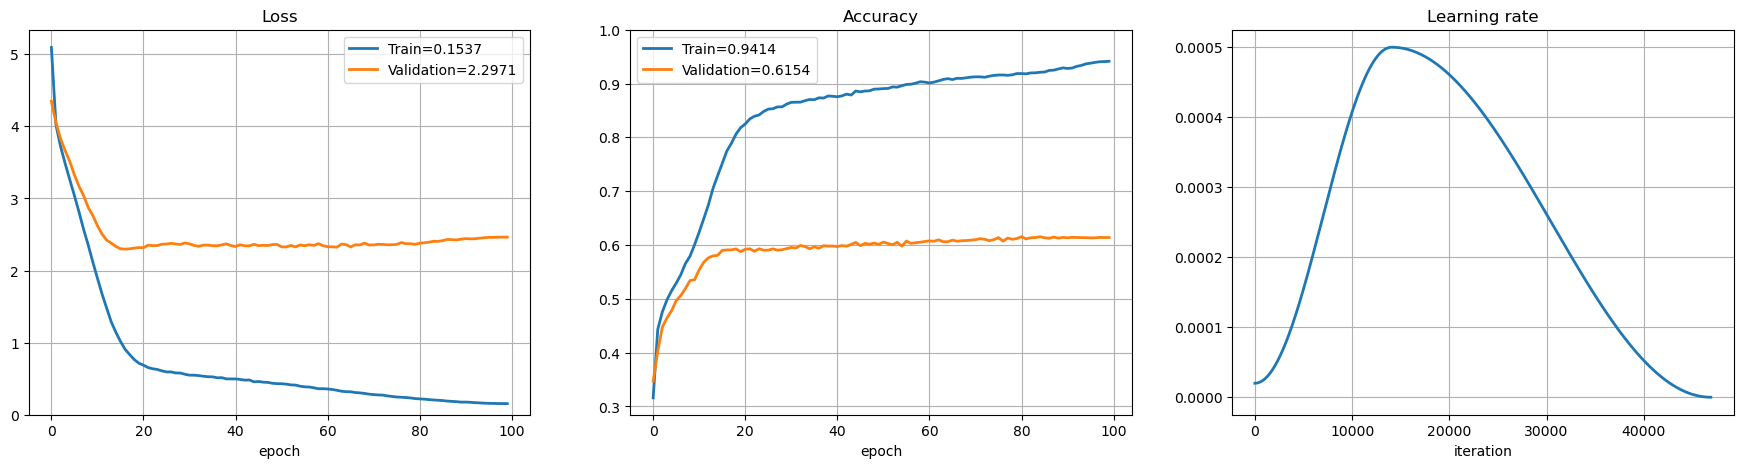

In [23]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

In [22]:
# oMdeol = Seq2Seq().to(DEVICE)
# oModel.load_state_dict(torch.load('Seq2Seq_v1.pt'))
# oModel.eval()

Seq2Seq(
  (oEncoder): EncoderRNN(
    (oEmbedding): Embedding(4769, 256, padding_idx=3)
    (oGRU): GRU(256, 512, bidirectional=True)
  )
  (oDecoder): DecoderRNN(
    (oEmbedding): Embedding(8139, 256)
    (oGRU): GRU(1280, 1024)
    (oLinear): Linear(in_features=2304, out_features=8139, bias=True)
  )
)

### Exercise (predict implementation)
Complete the `Predict` function implementation.  

Note: A [beam search](https://en.wikipedia.org/wiki/Beam_search) should be used instead of top 1 method.

In [60]:
from torch.distributions.categorical import Categorical
    
def Predict(oModel, lSrc, bTop1=False):
    MAX_LENGTH = 256
    N          = len(lSrc)
    DEVICE     = lSrc[0].device
    vTrgIn     = ???
    mTrgOut    = torch.zeros((N, MAX_LENGTH), device=DEVICE) #-- mTrgOut.shape = (N, T)
    
    #-- Enocde:
    mC = ???
    mH = ???

    for ii in range(MAX_LENGTH):
        #-- Decode:
        mZ, mH = ???
        
        if bTop1 == True:
            vTrgIn = ???
        else:
            vTrgIn = ???

        mTrgOut[:,ii] = vTrgIn

    #-- Keep sequences up to <EOS>:
    vIdx    = (mTrgOut == oTrgVocab['<EOS>']).int().argmax(dim=1)
    lTrgOut = [mTrgOut[ii,:vIdx[ii]] for ii in range(N)]
    
    return lTrgOut

In [25]:
import pandas as pd

dLang = pd.DataFrame(index=range(10), columns=['English', 'GT (Hebrew)', 'Generated'])

for ii in range(10):
    idx        = np.random.randint(nTest)
    vEng, vHeb = oTestSet[idx]
    lEng       = [vEng.to(DEVICE)]
    with torch.no_grad():
        vHebOut = Predict(oModel, lEng)[0].int()

    dLang.iloc[ii,:] = [Tensor2Line(oEngVocab, vEng[1:-1]), Tensor2Line(oHebVocab, vHeb[1:-1]), Tensor2Line(oHebVocab, vHebOut)]

dLang

,English,GT (Hebrew),Generated
0,please sign here .,נא לחתום כאן בבקשה .,חתום כאן בבקשה .
1,i love your place .,אני אוהב את המקום שלכם .,אני אוהב את המקום שלכם .
2,is tom cute ?,תום חמוד ?,תום הבריאות ?
3,he has ten cows .,יש לו עשר פרות .,יש לו עשר עשר .
4,well i lied .,ובכן שיקרתי .,שעון .
5,please come .,בבקשה <UNK> .,הצטרף בבקשה .
6,i need you .,אני זקוקה לך .,אני צריך אתכם .
7,i already apologized .,כבר ביקשתי סליחה .,כבר התנצלתי .
8,tom sipped some tea .,תום לגם מעט תה .,תום זיהה קצת תה .
9,we re all satisfied .,כולנו מרוצים .,כולנו מרוצים .


In [ ]:
# from torch.distributions.categorical import Categorical
    
# def Predict(oModel, lSrc, bTop1=False):
#     MAX_LENGTH = 256
#     N          = len(lSrc)
#     DEVICE     = lSrc[0].device
#     vTrgIn     = oTrgVocab['<SOS>'] * torch.ones(N, dtype=torch.int32, device=DEVICE)
#     mTrgOut    = torch.zeros((N, MAX_LENGTH),                          device=DEVICE) #-- mTrgOut.shape = (N, T)
    
#     #-- Enocde:
#     mC = oModel.oEncoder(lSrc) #-- mC.shape = (1, N, H)
#     mH = mC

#     for ii in range(MAX_LENGTH):
#         #-- Decode:
#         mZ, mH = oModel.oDecoder(vTrgIn, mC, mH) #-- mZ.shape = (N, V)
#                                                  #-- mH.shape = (L, N, H)
#         if bTop1 == True:
#             vTrgIn = mZ.argmax(dim=1)
#         else:
#             vTrgIn = Categorical(logits=mZ).sample()

#         mTrgOut[:,ii] = vTrgIn

#     #-- Keep sequences up to <EOS>:
#     vIdx    = (mTrgOut == oTrgVocab['<EOS>']).int().argmax(dim=1)
#     lTrgOut = [mTrgOut[ii,:vIdx[ii]] for ii in range(N)]
    
#     return lTrgOut